# Overview

The aim of the project is to build a model, which will predict property price based on its features. First, I preprocessed the data, which included:
- removing rows containing older valuations for the same property
- checking for missing values
- performing EDA (plotting distributions and correlations)
- feature engineering (e.g. dropping reduntant columns, log transforming right skewed numeric variables)
- checking importance of features using RFECV 
- scaling features
- modelling with Ridge Regression, SVR, XGBoost and ANNs

I compared models using MAE. XGBRegressor performed best with R^2: 0.707 and MAE: 0.232 on test set.



# Import of files and libraries

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from xgboost.sklearn import XGBRegressor
import scipy.stats as ss
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

In [151]:
data = pd.read_csv("/dane/house.csv")

In [0]:
# checking labels of columns
print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [152]:
# dropping unnecessary columns
data.drop(['yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

In [0]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987


# Data preprocessing

#### Handling duplicates

First, I will check number of unique values in each column, check if there are duplicate values based on id and how to handle them.

In [0]:
# checking number of unique values in each column
for col in data.columns:
    print(f"{col}: {data[col].nunique()}")
print(f"\nNumber of observations: {len(data)}")

id: 21436
date: 372
price: 4028
bedrooms: 13
bathrooms: 30
sqft_living: 1038
sqft_lot: 9782
floors: 6
waterfront: 2
view: 5
condition: 5
grade: 12
sqft_above: 946
sqft_basement: 306
yr_built: 116

Number of observations: 21613


Less ids than observations may indicate duplicated rows. Let's analyse the duplicates in more detail.

In [0]:
# extracting and sorting duplicated rows so that they are beside each other
duplicates = data[data.duplicated(subset="id", keep=False)].sort_values(by="id")

In [0]:
duplicates.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built
2497,1000102,20150422T000000,300000.0,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991
2496,1000102,20140916T000000,280000.0,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991
16814,7200179,20141016T000000,150000.0,2,1.00,840,12750,1.0,0,0,3,6,840,0,1925
16815,7200179,20150424T000000,175000.0,2,1.00,840,12750,1.0,0,0,3,6,840,0,1925
11434,109200390,20141020T000000,250000.0,3,1.75,1480,3900,1.0,0,0,4,7,1480,0,1980
11433,109200390,20140820T000000,245000.0,3,1.75,1480,3900,1.0,0,0,4,7,1480,0,1980
12418,123039336,20141208T000000,244900.0,1,1.00,620,8261,1.0,0,0,3,5,620,0,1939
12417,123039336,20140611T000000,148000.0,1,1.00,620,8261,1.0,0,0,3,5,620,0,1939
7793,251300110,20150114T000000,358000.0,3,2.25,2510,12013,2.0,0,0,3,8,2510,0,1988
7792,251300110,20140731T000000,225000.0,3,2.25,2510,12013,2.0,0,0,3,8,2510,0,1988


There are multiple rows for some properties, because they were valued more than once - they differ in date of pricing and price. I will remove the older valuations. 

In [153]:
# sorting data by id and date, so that all duplicated rows are beside each other 
# and valid row (with newest valuation) is first
data = data.sort_values(by=["id", "date"], ascending=[True, False])

In [154]:
# dropping duplicated rows (keeping first occurance i.e. with newest valuation) 
data.drop_duplicates(subset="id", inplace=True)

#### Feature engineering

There seems to be reduntant features in the dataset. Id is a uniqe feature with no predictive power. Date of valuation is a feature which leaks information about dependent variable (when using the model to predict the price of a propery, we won't have the date when this price was established since we won't have the price). These features will be removed.

The rest of the features are of different types:

* bedrooms: numeric
* bathrooms: numeric
* sqft_living: numeric
* sqft_lot: numeric
* floors: numeric
* waterfront: binary
* view: ordinal
* condition: ordinal
* grade: ordinal
* sqft_above: numeric
* sqft_basement: numeric
* yr_built: ordinal

I will turn the year the building was bulit into the age of building as the age is numeric and interpretable.
I will also compare features: sqft_living and sqft_above as they may contain a lot of identical values.

In [155]:
# turning yr_built to age
data["age"] = int(datetime.now().year)-data.yr_built

In [0]:
# counting number of identical values in sqft_living and sqft_above
print(f"There are {(data.sqft_living == data.sqft_above).sum()/data.shape[0]} identical values in columns sqft_living and sqft_above.")

There are 0.6071561858555701 identical values in columns sqft_living and sqft_above.


As over 60% of values in sqft_living and sqft_above overlap, let's investigate some of the observations in which these values differ.

In [0]:
data[data.sqft_living != data.sqft_above].head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,age,log_price
1,4,1.75,2060,26036,1.0,0,0,4,8,1160,900,72,13.380874
3,3,1.00,1430,7599,1.5,0,0,4,6,1010,420,89,12.367341
4,4,2.00,1650,3504,1.0,0,0,3,7,760,890,68,12.905450
5,4,2.75,2220,5310,1.0,0,0,5,7,1170,1050,68,13.429848
13,3,2.25,1530,1245,2.0,0,0,3,9,1050,480,5,13.049793


It seems that sqft_living is a sum of sqft_above and sqft_basement. Let's check if it's true for all the records.

In [0]:
if (data.sqft_living == (data.sqft_above + data.sqft_basement)).all():
    print("sqft_living is a sum of sqft_above and sqft_basement")
else:
    print("sqft_living is NOT a sum of sqft_above and sqft_basement")

sqft_living is a sum of sqft_above and sqft_basement


So I can safely remove sqft_living without loosing any information.

In [156]:
# dropping redundant columns
data.drop(["id", "date", "yr_built", "sqft_living"], axis=1, inplace=True)

In [157]:
# resetting index
data.reset_index(inplace=True, drop=True)

In [0]:
# checking for missing values
if data.isnull().any().any()==False:
    print("There are no missing values.")
else:
    print("There are missing values to be handled.")

There are no missing values.


# EDA

Let's explore visually distributions and correlations between variables.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


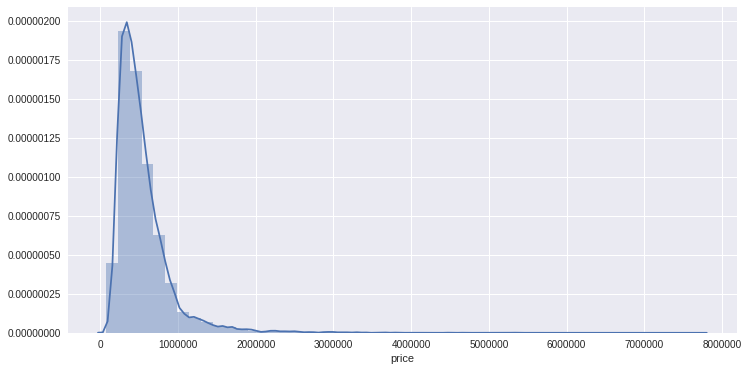

In [0]:
# plotting histogram of price
plt.figure(figsize=(12,6))
sns.distplot(data.price)

The distribution of property prices is right skewed. In order to reduce skewness I will use the logarithm tranformation of prices.

In [158]:
# transformig price using logarithm
data["log_price"] = np.log(data.price)

In [159]:
# dropping "old" price column
data.drop("price", axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


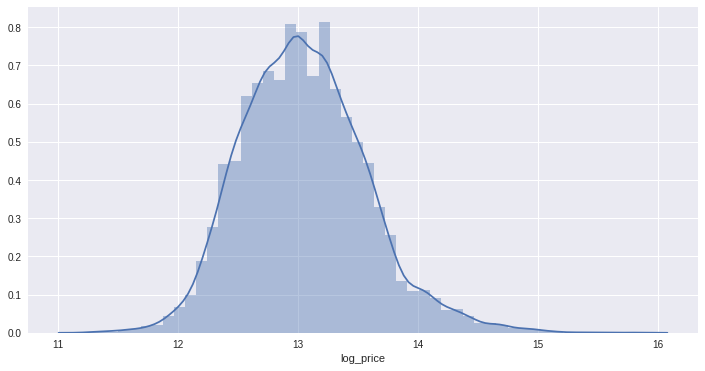

In [0]:
# plotting histogram of log_price
plt.figure(figsize=(12,6))
sns.distplot(data.log_price)

Logarithmic transformation helped a lot, as log_price has normal distibution.

Now I will investigate the correlations between features, especially between dependent variable and independent variables. I will check the strength of linear correlations on the heatmap and use scatter plots of log_price and independent features to check for non-linear relationships.


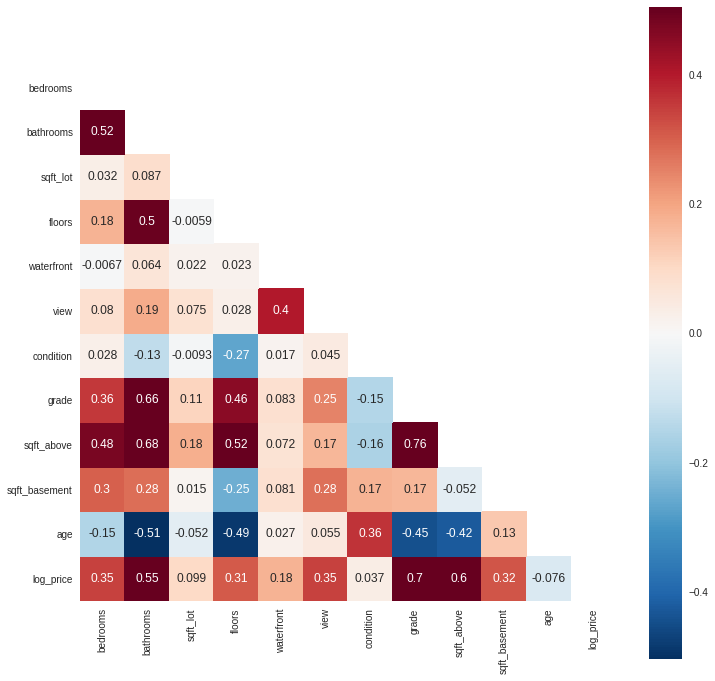

In [0]:
# plotting a diagonal correlations matrix (heatmap with mask)

# calculating linear correlations matrix
corr = np.corrcoef(data.values.T)
# creating mask with zeros 
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,12))
with sns.axes_style("white"):
  ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, yticklabels=data.columns.values, xticklabels=data.columns.values)

The most interesting part of the heatmap is the last row of squares showing the strength of the correlation between log_price and independent variables. Features which have the highest correlation with log_price (all positive):

* grade
* sqft_above
* bathrooms


Now is the proper moment to split the dataset into train, validation and test sets in order to prevent leaking meaningful information from the test set.



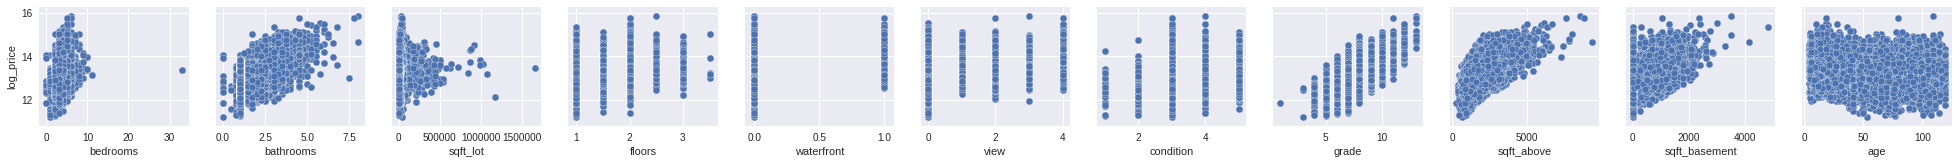

In [0]:
# scatter plots for log_price and all independent variables
sns.pairplot(data,
            x_vars=['bedrooms', 'bathrooms', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'age'],
            y_vars="log_price")

The relationships on the plots are distorted by outliers. I will investigate the distributions of numeric features in more detail by plotting the histograms.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


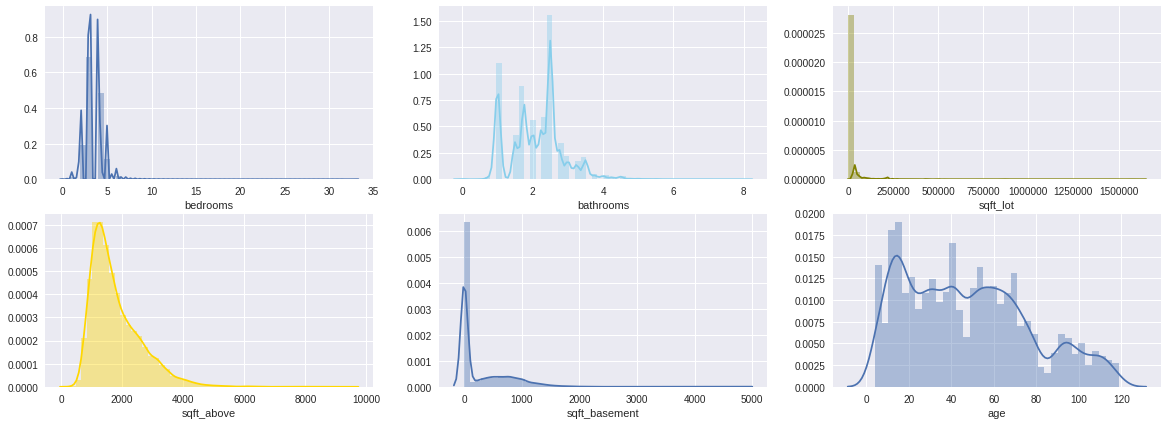

In [0]:
# plotting ditributions of numeric features
f, axes = plt.subplots(2, 3, figsize=(20, 7), sharex=False)
sns.distplot( data["bedrooms"], ax=axes[0, 0])
sns.distplot( data["bathrooms"] , color="skyblue", ax=axes[0, 1])
sns.distplot( data["sqft_lot"] , color="olive", ax=axes[0, 2])
sns.distplot( data["sqft_above"] , color="gold", ax=axes[1, 0])
sns.distplot( data["sqft_basement"], ax=axes[1, 1])
sns.distplot( data["age"], ax=axes[1, 2])

Apart from the age, all of the numeric features are heavily right skewed with some possible outliers in the right tail. Using raw values of these features might influence the result of the modelling e.g. with linear regression (taking a look at the scatter plot of log_price and number of bedrooms, we can see that the outlier value with over 30 bedrooms will influence the slope of the regression line). Now I have at least two ways to deal with these features:

* remove outliers (using probably clustering methods basing on distance like DBSCAN rather than zscore, which relies on mean which in case of non-gaussian distributions will be skewed.)
* transform skewed features, preferably using log as it's well suited to smooth right skewed distributions and moreover, I use log of the dependent variable so the interpretation will be easier.

As removing outliers always mean loosing some information and truncating dataset (and in this case I don't have reasons to suspect that outliers are the effect of mistake in data collection) I will go for log transformation.



In [160]:
# log transformation of right-skewed numeric features (excluding age)
data["log_bedrooms"] = np.log(data.bedrooms+1)
data["log_bathrooms"] = np.log(data.bathrooms+1)
data["log_sqft_lot"] = np.log(data.sqft_lot+1)
data["log_sqft_above"] = np.log(data.sqft_above+1)
data["log_sqft_basement"] = np.log(data.sqft_basement+1)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


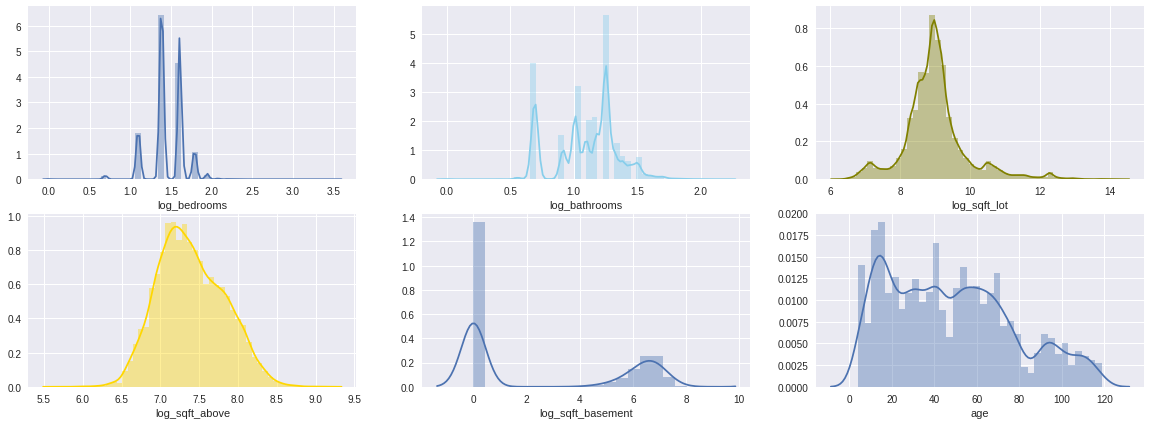

In [0]:
# plotting logged features and age
f, axes = plt.subplots(2, 3, figsize=(20, 7), sharex=False)
sns.distplot( data["log_bedrooms"], ax=axes[0, 0])
sns.distplot( data["log_bathrooms"] , color="skyblue", ax=axes[0, 1])
sns.distplot( data["log_sqft_lot"] , color="olive", ax=axes[0, 2])
sns.distplot( data["log_sqft_above"] , color="gold", ax=axes[1, 0])
sns.distplot( data["log_sqft_basement"], ax=axes[1, 1])
sns.distplot( data["age"], ax=axes[1, 2])

The log transformation helped with all the features apart from sqft_basement. It's no wonder taking into account that most properties in the dataset don't have basement at all. I will try discretization of the feature.

In [0]:
print(f"Most frequent values for sqft_basement: \n{data.sqft_basement.value_counts(normalize=True)[:10]}")

Most frequent values for sqft_basement: 
0       0.607156
600     0.010263
700     0.010030
500     0.009843
800     0.009610
400     0.008584
1000    0.006858
900     0.006671
300     0.006578
480     0.004945
Name: sqft_basement, dtype: float64


In [0]:
print(f"Maximum value for sqft_basement: {data.sqft_basement.max()}")

Maximum value for sqft_basement: 4820


In [161]:
# binning sqft_basement into 4 bins with following labels and intervals:
# 0: 0-1
# 1: 1-500
# 2: 500-1000
# 3: 1000-4820
# feature will be treated as category by default, converting to int, as it's an ordinal feature 
data.sqft_basement = pd.cut(data.sqft_basement, [0, 1, 500, 1000, 4820], 
                            labels = [0, 1, 2, 3], right=True, include_lowest=True).astype(int)

In [0]:
print(f"Distribution of values in the bins: \n{data.sqft_basement.value_counts()}")

Distribution of values in the bins: 
0    13015
2     3915
1     2650
3     1856
Name: sqft_basement, dtype: int64


In [162]:
# dropping features which were log transformed
data.drop(["bedrooms", "bathrooms", "sqft_lot", "sqft_above", "log_sqft_basement"], axis=1, inplace=True)

# Modelling

Now is the proper moment to split the dataset into train, validation and test sets.

#### Assigning variables

In [163]:
# assigning X and y
y = data["log_price"]
X = data.drop("log_price", axis=1)

In [164]:
# splitting into train, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                          random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, 
                                                          random_state=52)

#### Feature selection

In [0]:
print(f"There are {X_train.shape[1]} columns.")

There are 11 columns.


There are only 11 features so I don't need to perform very rigid feature selection. However, if there are reduntant features with little predictive power getting rid of them will improve model fit. I will use recursive feature elemination with cross validation (RFECV). This method has many benefits:

* features' importances are calculated recursively
* we don't have to state the number of features beforehand as best number of features is selected based on cross-validation results.

I will use RandomForestRegressor as estimator in RFECV as it captures non-linear relationships and is more stable than single DecisionTree. 

In [23]:
# recursively selecting features
selector = RFECV(RandomForestRegressor(n_estimators=30, min_samples_leaf=3, random_state=52), step=1, cv=5)
selector = selector.fit(X_train, y_train)
print(f"Mask indicating important columns as True: \n{selector.support_}")

Mask indicating important columns as True: 
[ True  True  True  True  True  True  True  True  True  True  True]


All of the features improve performance of the estimator, so I will leave all of the them for modelling. 

## Pipelines for modelling

#### Scaling

Pipeline will include scaling independent variables, so that the magnitude of coefficients is not biased by the magnitude of the values of features. Tree-based algorithms don't need scaling. It might seems strange that I repeat scaling in the pipeline, but when we use cross-validation (RandomSearchCV uses it) parameters for scaling like mean and std should be calculated anew for every fold. 

#### Models

I will check following models:
- **Ridge Regression**: Linear Regression with L2 regularization to prevent overfitting. As I checked that probably all features are important I don't need to use L1 norm (Lasso regression), which otherwise has the advantage of leading coefficients to zero.
- **SVR**: Support Vector Machine with kernel rbf.
- **XGBRegressor**: boosted random forest, which means that each tree is built iteratively, improving on the performance of the earlier trees.

I will use RandomizedSearchCV to search through grids of parameters for different models. It's quicker than GridSearchCV, as it doesn't check each combination of parameters but specified number of randomly selected combinations of parameters from given distributions.

Then I will check if ANN performs better. I will check several architectures with 1-3 Dense layers and differing number of neurons. I will use Dropout in some architectures for regularisation.

#### Metrics

I also have to decide on the best metric for comparing results of different regression models. The most popular one for regression is **MSE**, however it has some charasteristics which can be disadvantagous in this case:
- sensitive to outliers (penalizes them a lot by squaring the error): it will be an advantage if I wanted to easily detect and investigate unexpected values. As I am aware that there are outliers in my sample I don't need to inflate the error because of them.

**MAE** seems a better choice for this task, as it is more robust to outliers. Normally it has an easy interpretation but in this case as the dependent variable is logged, interpretation will be mean error expressed in logged pice.

**R^2** is also an interesting metric. Its advantages in the context of this task:
- always between -∞ and 1, doesn't depend on the scale of variables
- easy interpretation: how much variance of the dependent variable around its mean is explained by the model
- contains a baseline model - mean of the response variable and compares results of the modelling against it.

So I will use MAE and R^2 to compare goodness of fit of different models (for ANNs I will use only MAE, which is already implemented in keras).









In [115]:
models = [
    Pipeline([("scaler",StandardScaler()),
        ("model",Ridge())]), 
    Pipeline([("scaler",StandardScaler()),
              ("model",SVR())]),
    Pipeline([("model", XGBRegressor())])         
]
param_grids = [
    {"model__alpha": ss.uniform(0.01,100)},
    
    {"model__C": ss.uniform(0.01,100),
    "model__gamma": ss.uniform(0.001,0.01)},
    
    {"model__n_estimators":ss.randint(30,200),
    "model__learning_rate":ss.uniform(0.01,0.3),
    "model__max_depth": ss.randint(3,20),
    "model__reg_lambda":ss.uniform(0.1,3)}
]
for model, param_grid in zip(models, param_grids):
    
    cv = RandomizedSearchCV(cv=5, 
                        estimator=model,
                        param_distributions=param_grid,
                        n_iter=30)
    
    cv.fit(X_train, y_train)
    print(model)
    print(f"R^2: {r2_score(y_val, cv.best_estimator_.predict(X_val))}, {cv.best_params_}")
    print(f"MAE: {mean_absolute_error(y_val, cv.best_estimator_.predict(X_val))}, {cv.best_params_}")

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])
R^2: 0.6531853644114749, {'model__alpha': 15.390110653347856}
MAE: 0.24321967123962857, {'model__alpha': 15.390110653347856}
Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])
R^2: 0.6797807331144959, {'model__C': 53.40035547690095, 'model__gamma': 0.010403229543045633}
MAE: 0.23195449247619707, {'model__C': 53.40035547690095, 'model__gamma': 0.010403229543045633}
Pipeline(memory=None,
     steps=[('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate

XGBRegressor performed best with R^2=0.697 and MAE=0.223 on validation set. It means that XGBRegressor model explains almost 70% of variance of the response variable. However, performance of SVR and Ridge Regression was only slighly worse. Let's check of ANN will beat this result.

#### ANN

In [165]:
# scaling data is necessary for ANN
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
X_val_sc = scaler.transform(X_val)

In [166]:
def build_ann(list_of_layers):
    '''Function building and compiling ANN.'''
    model = Sequential()
    for layer in list_of_layers:
        model.add(layer)
    model.summary() 
  
    model.compile(loss='mean_absolute_error',
               optimizer="adam", 
               metrics=["mean_absolute_error"])
    return model

In [167]:
def evaluate_ann(model, X_train, X_val, y_train, y_val, filename, batch_size=32):
    '''Function evaluating ANN on validation set with Early Stopping and loading weights from the best epoch.'''
    early_stopping = EarlyStopping(patience=3, monitor="val_loss")
    take_best_model = ModelCheckpoint(str(filename)+".h5py", save_best_only=True)

    model.fit(X_train, y_train, epochs=100, validation_split=0.2,
           batch_size=batch_size, 
           callbacks=[early_stopping, take_best_model])

    model.load_weights(str(filename)+".h5py")
    return model.evaluate(X_val, y_val)[1]

In [168]:
# ANN's architectures to check
models =  { 
        "1_Dense_30_n": [Dense(30,activation="relu", input_shape=(X_train.shape[1],)),
                        Dense(1)],  
    
        "1_Dense_50_n": [Dense(50,activation="relu", input_shape=(X_train.shape[1],)),
                        Dense(1)],
    
        "1_Dense_100_n": [Dense(100,activation="relu", input_shape=(X_train.shape[1],)),
                        Dense(1)],
        
        "2_Dense_100_50_n": [Dense(100,activation="relu", input_shape=(X_train.shape[1],)),
                             Dropout(0.5),
                            Dense(50, activation="relu"),
                            Dense(1)],
        "3_Dense_200_100_10_n": [Dense(200,activation="relu", input_shape=(X_train.shape[1],)),
                                 Dropout(0.5),
                                Dense(100, activation="relu"),
                                Dense(10, activation="relu"),
                                Dense(1)]
}

In [169]:
# evaluating ANNs and creating list of MAE results
lst = []
for model, params in models.items():
    mae = (evaluate_ann(build_ann(params), X_train_sc, X_val_sc, y_train, y_val, model))
    lst.append(mae)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 30)                360       
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 31        
Total params: 391
Trainable params: 391
Non-trainable params: 0
_________________________________________________________________
Train on 12389 samples, validate on 3098 samples
Epoch 1/100
12389/12389 [==============================] - 3s 223us/step - loss: 7.9376 - mean_absolute_error: 7.9376 - val_loss: 3.1637 - val_mean_absolute_error: 3.1637

In [173]:
ann_results = pd.DataFrame(list(zip(models.keys(), lst)), 
                           columns=["model", "MAE"]).sort_values(by="MAE", ascending=True).reset_index(drop=True)
ann_results

,model,MAE
0,2_Dense_100_50_n,0.237276
1,1_Dense_50_n,0.245334
2,1_Dense_100_n,0.248332
3,3_Dense_200_100_10_n,0.249635
4,1_Dense_30_n,0.258757


ANNs scored worse than XGBRegressor in terms of MAE.

Best model specification for XGBRegressor included boundry value for reg_lambda parameter. Now I will do RandomizedSearchCV for XGBREgressor again extending parametr grid for reg_lambda and check how it scores on validation set.

In [171]:
model = XGBRegressor()         

param_grid = {"model__n_estimators":ss.randint(30,200),
    "model__learning_rate":ss.uniform(0.01,0.3),
    "model__max_depth": ss.randint(3,20),
    "model__reg_lambda":ss.uniform(0.1,5)}
    
cv = RandomizedSearchCV(cv=5, 
                        estimator=model,
                        param_distributions=param_grid,
                        n_iter=50)
    
cv.fit(X_train, y_train)
print(f"R^2: {r2_score(y_val, cv.best_estimator_.predict(X_val))}, {cv.best_params_}")
print(f"MAE: {mean_absolute_error(y_val, cv.best_estimator_.predict(X_val))}, {cv.best_params_}")

R^2: 0.6829444399195876, {'model__learning_rate': 0.12606971322648775, 'model__max_depth': 19, 'model__n_estimators': 124, 'model__reg_lambda': 4.696142641903403}
MAE: 0.23261243951216068, {'model__learning_rate': 0.12606971322648775, 'model__max_depth': 19, 'model__n_estimators': 124, 'model__reg_lambda': 4.696142641903403}


#### Result on test set

In [172]:
# calculating MAE and R^2 on test set using best XGBREgressor
print(f"R^2: {r2_score(y_test, cv.best_estimator_.predict(X_test))}")
print(f"MAE: {mean_absolute_error(y_test, cv.best_estimator_.predict(X_test))}")

R^2: 0.7074232154312472
MAE: 0.23224836550837272


In [177]:
feature_importances = sorted(list(zip(cv.best_estimator_.feature_importances_, X.columns)),reverse=True)

In [178]:
print("Relative importance of features:")
print(feature_importances)

Relative importance of features:
[(0.21589205, 'age'), (0.19490255, 'log_sqft_above'), (0.17691155, 'log_sqft_lot'), (0.12593703, 'grade'), (0.06896552, 'log_bathrooms'), (0.055472262, 'condition'), (0.05397301, 'sqft_basement'), (0.032983508, 'view'), (0.028485756, 'waterfront'), (0.025487257, 'log_bedrooms'), (0.020989506, 'floors')]


It turned out that the most important feature (in terms of average decrease in impurity) is age of the property, followed by the living area above ground level and the area of the lot. The least important feature is number of floors of the building. 

# Ideas for further development

Best model explains 70% of variance of dependent variable on test set. In order to achieve better performance for the task I could try:
- encoding ordinal features
- creating new features which are interactions of other features
- using more sophisticated algorithms for tuning hyperparameters like hyperopt
- trying more architectures for ANN

Additionally, for the sake of comparability of the results it will be beneficial to create custom metric for keras to calculate R^2 of ANNs.